# COMPARATIVE ANALYSIS
This notebook takes the DESeq2 outputs for each of the seven focal ant species in our screen, as well as the table of ortholog groups from OrthoMCL. It calculates the observed number of concordant differentially expressed genes across all combinations of species. It also identifies the genes that are concordantly differentially expressed in any subset of five species. 

## Table of Contents
1  Create data frames of p_values for all species

2  Create table of orthologs

3  Create new columns to allow filtering to single copy orthologs

4  Join the p-value files together

5  Check table for all significant genes

6  Check number of orthologous DEGs per species

7  Find number of concordant DEGs

8  Calculate average concordance

9  Concordance simulations

10  combine both datasets

In [1]:
import os

In [208]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import IUPAC
from __future__ import division
import math
from ete3 import Tree

In [208]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
import numpy as np
import pandas as pd

In [208]:
from   collections import Counter
import datetime
from   itertools import combinations
import random
import re
import tempfile

### Create data frames of p_values for all species

In [244]:
species = ['Acromyrmex', 'Camponotus', 'Harpegnathos', 'Odontomachus', 'Ooceraea', 'Solenopsis', 'Dinoponera']
sp_short = ['Aech', 'Cpla', 'Hsal', 'Orug', 'Obir', 'Sinv', 'Dqua']

all_pvalues =   ['Acromyrmex_echinatior_deseq.txt',
                 'Camponotus_planatus_deseq.txt',
                 'Dinoponera_quadriceps_deseq.txt',
                 'Odontomachus_ruginodis_deseq.txt',
                 'Ooceraea_biroi_deseq.txt',
                 'Solenopsis_invicta_deseq.txt'
                ]
orthologs = 'groups.txt'

In [245]:
# create a dictionary of dataframes, with key being the genus.
df_pval_dic = { sp:pd.read_csv(fp, sep=',', index_col=0) for sp, fp in zip(species,all_pvalues) }


In [246]:
for sp in species:
    print(sp, df_pval_dic[sp].shape)

('Acromyrmex', (12176, 6))
('Camponotus', (17993, 6))
('Harpegnathos', (12302, 6))
('Odontomachus', (25458, 6))
('Ooceraea', (13640, 6))
('Solenopsis', (15103, 6))
('Dinoponera', (11544, 6))


In [247]:
df_pval_dic['Ooceraea'].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Obir|LOC105286130,149.377331,3.280282,0.242936,13.502682,1.507853e-41,1.591237e-37
Obir|LOC105278399,404.260354,2.737047,0.212061,12.906886,4.116148e-38,2.171886e-34
Obir|LOC105275236,2868.241806,-1.690624,0.132965,-12.714766,4.895723e-37,1.722152e-33
Obir|LOC105286131,64.730374,2.792131,0.250286,11.155772,6.710789e-29,1.770474e-25
Obir|LOC105285466,2635.659534,-1.597511,0.144097,-11.086378,1.460831e-28,3.083229e-25


### Create table of orthologs

In [248]:
# create dataframe of orthologs
df_orthologs = pd.read_csv(orthologs, sep=':', header=None, names=["group","orthologs"])
df_orthologs.head()# create new columns to allow filtering to single copy orthologs

,group,orthologs
0,ILPpaperGroups1000,Aech|LOC105155080 Cbir|LOC105287483 Obir|LOC1...
1,ILPpaperGroups1001,Acep|LOC105617370 Acep|LOC105617724 Acep|LOC1...
2,ILPpaperGroups1002,Acep|LOC105617602 Acep|LOC105621803 Acep|LOC1...
3,ILPpaperGroups1003,Acep|LOC105619009 Acep|LOC105619010 Acep|LOC1...
4,ILPpaperGroups1004,Acep|LOC105619475 Cbir|LOC105275943 Cbir|LOC1...


### Create new columns to allow filtering to single copy orthologs

In [249]:
# create column with number of orthologs in group:
df_orthologs["group_size"] = df_orthologs.apply(lambda s: len(s["orthologs"].split()), axis=1)

# group size only counting the 7 ant species of interest:
df_orthologs["group_size_7"] = df_orthologs.apply(lambda s: len([o for o in s["orthologs"].split() if o[:4] in sp_short]), axis=1)

# create column with number of unique species present:
df_orthologs["group_size_unique"] = df_orthologs.apply(lambda s: len(set([g[:4] for g in s['orthologs'].split()])), axis=1)

# unique set of 7 ant species:
df_orthologs["group_size_7_unique"] = df_orthologs.apply(lambda s: len(set([g[:4] for g in s['orthologs'].split() if g[:4] in sp_short])), axis=1)

In [250]:
df_orthologs.head()

,group,orthologs,group_size,group_size_7,group_size_unique,group_size_7_unique
0,ILPpaperGroups1000,Aech|LOC105155080 Cbir|LOC105287483 Obir|LOC1...,1127,295,17,7
1,ILPpaperGroups1001,Acep|LOC105617370 Acep|LOC105617724 Acep|LOC1...,292,112,19,7
2,ILPpaperGroups1002,Acep|LOC105617602 Acep|LOC105621803 Acep|LOC1...,270,99,19,7
3,ILPpaperGroups1003,Acep|LOC105619009 Acep|LOC105619010 Acep|LOC1...,257,106,19,7
4,ILPpaperGroups1004,Acep|LOC105619475 Cbir|LOC105275943 Cbir|LOC1...,251,76,16,7


In [251]:
scaos = df_orthologs[(df_orthologs.group_size_7 == 7) & (df_orthologs.group_size_7_unique == 7)]
scos = df_orthologs[(df_orthologs.group_size == 7) & (df_orthologs.group_size_unique == 7)]
    

In [252]:
scaos.shape

(5581, 6)

scaos variable ("single-copy ant orthologs") is a dataframe containing 5581 single-copy orthologs, based on the ortholog table calculated for many ants, plus other hymenoptera genes.

### Join the p-value files together
All files will be indexed by ortholog group.

In [253]:
df_combined = scaos.apply(lambda s: pd.Series(sorted([o for o in s["orthologs"].split() if o[:4] in sp_short])), axis=1)
df_combined.columns = sorted(sp_short)

In [254]:
df_combined.head()

,Aech,Cpla,Dqua,Hsal,Obir,Orug,Sinv
305,Aech|LOC105153097,Cpla|SGF61405,Dqua|LOC106749891,Hsal|LOC105181067,Obir|LOC105281216,Orug|SGF68562,Sinv|LOC105201217
331,Aech|LOC105144379,Cpla|SGF47786,Dqua|LOC106743402,Hsal|LOC105181117,Obir|LOC105282301,Orug|SGF65534,Sinv|LOC105194815
367,Aech|LOC105154742,Cpla|SGF57622,Dqua|LOC106742675,Hsal|LOC105184475,Obir|LOC105281047,Orug|SGF78634,Sinv|LOC105203057
413,Aech|LOC105151083,Cpla|SGF65369,Dqua|LOC106742289,Hsal|LOC105180743,Obir|LOC105287676,Orug|SGF86030,Sinv|LOC105198509
423,Aech|LOC105149040,Cpla|SGF52740,Dqua|LOC106748414,Hsal|LOC105185999,Obir|LOC105277964,Orug|SGF81562,Sinv|LOC105200782


In [255]:
cols_to_join = ["baseMean","log2FoldChange","pvalue","padj"]   #note that pvalue is the unadjusted pval, and padj is p after fdr correction
for sp,gen in zip(sp_short,species):
    p_to_join = df_pval_dic[gen][cols_to_join]
    p_to_join.columns = [ "{}_{}".format(sp,c) for c in cols_to_join]
    df_combined = df_combined.join(p_to_join, how='left', on=sp)

In [256]:
df_pval_dic["Dinoponera"].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Dqua|LOC106751227,300.153821,4.557719,0.378444,12.043315,2.103297e-33,2.133584e-29
Dqua|LOC106748522,92.910797,4.467935,0.375646,11.894012,1.271494e-32,6.449020e-29
Dqua|LOC106745803,4501.592770,-1.891300,0.237467,-7.964467,1.659377e-15,4.833160e-12
Dqua|LOC106750236,340.535161,-3.137663,0.394807,-7.947325,1.905820e-15,4.833160e-12
Dqua|LOC106748393,260.116159,-2.194798,0.290329,-7.559682,4.040549e-14,8.197466e-11


In [257]:
df_combined.head()

,Aech,Cpla,Dqua,Hsal,Obir,Orug,Sinv,Aech_baseMean,Aech_log2FoldChange,Aech_padj,...,Orug_padj,Obir_baseMean,Obir_log2FoldChange,Obir_padj,Sinv_baseMean,Sinv_log2FoldChange,Sinv_padj,Dqua_baseMean,Dqua_log2FoldChange,Dqua_padj
305,Aech|LOC105153097,Cpla|SGF61405,Dqua|LOC106749891,Hsal|LOC105181067,Obir|LOC105281216,Orug|SGF68562,Sinv|LOC105201217,839.829550,-0.005591,9.889660e-01,...,0.471735,2227.754133,0.432653,0.041655,391.232256,-0.051518,0.585876,1510.157120,0.081555,0.892676
331,Aech|LOC105144379,Cpla|SGF47786,Dqua|LOC106743402,Hsal|LOC105181117,Obir|LOC105282301,Orug|SGF65534,Sinv|LOC105194815,244.784487,1.460857,6.072771e-07,...,0.891570,793.978290,-0.007736,0.992221,226.248598,0.423662,0.000781,1583.759274,0.385693,0.674791
367,Aech|LOC105154742,Cpla|SGF57622,Dqua|LOC106742675,Hsal|LOC105184475,Obir|LOC105281047,Orug|SGF78634,Sinv|LOC105203057,306.311466,-0.077285,7.839781e-01,...,0.000016,2189.024661,-0.103909,0.871456,407.541439,0.260069,0.019039,249.299731,-0.438132,0.333082
413,Aech|LOC105151083,Cpla|SGF65369,Dqua|LOC106742289,Hsal|LOC105180743,Obir|LOC105287676,Orug|SGF86030,Sinv|LOC105198509,92.576057,0.841557,4.204105e-02,...,0.605464,83.684642,-0.166003,0.789415,45.880269,0.219733,0.551058,902.459992,0.185418,0.810774
423,Aech|LOC105149040,Cpla|SGF52740,Dqua|LOC106748414,Hsal|LOC105185999,Obir|LOC105277964,Orug|SGF81562,Sinv|LOC105200782,102.323539,1.464132,1.584354e-08,...,0.612367,1136.701183,0.179205,0.608615,867.414114,0.762431,0.001467,1946.216627,-0.244684,0.793433


In [258]:
# save to file
#df_combined.to_csv("ortholog_pvalue_table.csv")

### Check table for all significant genes

In [260]:
pcols = ["{}_{}".format(sp,"padj") for sp in sp_short] # a list of all the pvalue columns
lfc_cols = [ "{}_log2FoldChange".format(s) for s in sp_short ] # a list of all the LFC columns

mask = (df_combined[pcols] <= 0.05).all(axis=1)

print("{} orthologs found with all p-values (adjusted) <= 0.05".format(mask.sum()))
df_combined[mask]


1 orthologs found with all p-values (adjusted) <= 0.05


,Aech,Cpla,Dqua,Hsal,Obir,Orug,Sinv,Aech_baseMean,Aech_log2FoldChange,Aech_padj,...,Orug_padj,Obir_baseMean,Obir_log2FoldChange,Obir_padj,Sinv_baseMean,Sinv_log2FoldChange,Sinv_padj,Dqua_baseMean,Dqua_log2FoldChange,Dqua_padj
2059,Aech|LOC105147653,Cpla|SGF53173,Dqua|LOC106750697,Hsal|LOC105188195,Obir|LOC105278524,Orug|SGF66168,Sinv|LOC105200753,68.272121,2.711926,4.391351e-10,...,0.004607,1228.728806,1.381716,2.963560e-15,626.264624,2.441594,3.473843e-16,177.224011,1.086033,0.037204


This last cell shows that there is only one gene that has a p-value (adjusted) ≤ 0.05 in all seven species. This gene is also over-expressed in reproductives in all seven species (ie, it is concordantly expressed in all seven species).

### Check number of orthologous DEGs per species
The number of orthologous DEGs will be smaller than the total number of DEGs for each individual species, since only the single-copy orthologs are represented.

In [262]:
pvs = [ sp + "_padj" for sp in sp_short]
species_specific_deg_num = []  # this variable is used later for the simulations
print("{:<13s} {:<6s} {:<5s}".format("SPECIES", "ODEGS", "DEGs"))
for p,sp in zip(pvs, species):
    species_specific_deg_num.append((df_combined[p] <= 0.05).sum())
    print("{:<13s} {:-5d} {:-5d}".format(sp, (df_combined[p] <= 0.05).sum(), (df_pval_dic[sp]["padj"] <= 0.05).sum()))

SPECIES       ODEGS  DEGs 
Acromyrmex     1050  2262
Camponotus     2579  5304
Harpegnathos     16    35
Odontomachus   2270  4987
Ooceraea        363   784
Solenopsis     1925  4116
Dinoponera      171   408


In [263]:
df_combined[df_combined.Obir == "Obir|LOC105278524"][lfc_cols]  # ILP2

,Aech_log2FoldChange,Cpla_log2FoldChange,Hsal_log2FoldChange,Orug_log2FoldChange,Obir_log2FoldChange,Sinv_log2FoldChange,Dqua_log2FoldChange
2059,2.711926,1.081158,0.898978,1.123209,1.381716,2.441594,1.086033


In [264]:
df_combined[df_combined.Obir == "Obir|LOC105283606"][pvs]  # ILP1 

,Aech_padj,Cpla_padj,Hsal_padj,Orug_padj,Obir_padj,Sinv_padj,Dqua_padj
8648,0.022555,0.006219,0.000114,0.120454,0.02609,0.000009,0.58577


### Find number of concordant DEGs
While there is only a single gene differentially expressed across all seven species, there are varied numbers of genes significant and concordant among all the combinations of those seven species. Attempting to draw a Venn diagram would be of little use, as it becomes difficult to evaluate each comparison and see trends among so many sets.
Thus, here we will identify the number of genes that are signficant and concordant for each possible combination of the seven species, and plot the values against the number of species compared.

In [265]:
df_combined[mask][lfc_cols]

,Aech_log2FoldChange,Cpla_log2FoldChange,Hsal_log2FoldChange,Orug_log2FoldChange,Obir_log2FoldChange,Sinv_log2FoldChange,Dqua_log2FoldChange
2059,2.711926,1.081158,0.898978,1.123209,1.381716,2.441594,1.086033


In [266]:
c = {i:[] for i in np.arange(len(species)) + 1}
for n in np.arange(len(species)) + 1:
    for combo in combinations(zip(pcols,lfc_cols), n):
        ps,ls = list(zip(*combo))
        ps = list(ps)
        ls = list(ls)
        concordant_degs = ((
                            df_combined[ps] <= 0.05
                             ).all(axis=1) & (
                            abs((df_combined[ls] / abs(df_combined[ls])).sum(axis=1)) == len(ls)
                                        ) 
                            )
        #print("# sp = {0} # cdegs = {1}".format(len(ls), concordant_degs.sum()))
        c[n].append(concordant_degs.sum())
df_cdegs = pd.DataFrame({ k:pd.Series(v) for k,v in c.items()})

In [267]:
df_cdegs

,1,2,3,4,5,6,7
0,1050.0,386.0,5,2,1.0,1.0,1.0
1,2579.0,7.0,197,2,2.0,1.0,NaN
2,16.0,276.0,41,5,2.0,2.0,NaN
3,2270.0,88.0,249,2,2.0,1.0,NaN
4,363.0,542.0,11,23,1.0,2.0,NaN
5,1925.0,31.0,2,130,2.0,1.0,NaN
6,171.0,7.0,2,5,18.0,1.0,NaN
7,NaN,1346.0,6,32,2.0,NaN,NaN
8,NaN,123.0,2,3,4.0,NaN,NaN
9,NaN,787.0,33,7,2.0,NaN,NaN


In [268]:
#df_cdegs.to_csv("concordant_degs_observed_numbers.csv")

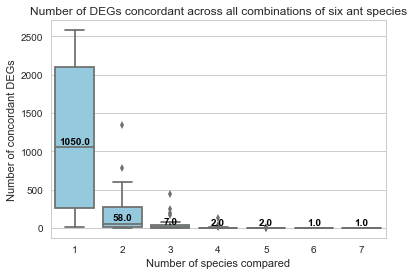

In [269]:
sns.set_style("whitegrid")
ax = sns.boxplot(df_cdegs, color="skyblue")

medians = df_cdegs.median().values
median_labels = [str(x) for x in medians]

pos = np.arange(len(medians)) 
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 40, median_labels[tick], 
            horizontalalignment='center', size='medium', color='k', weight='semibold')
    
    
plt.title("Number of DEGs concordant across all combinations of six ant species")
plt.xlabel("Number of species compared")
plt.ylabel("Number of concordant DEGs")
plt.savefig("concordant_degs_observed.png")

### Calculate average concordance

In [270]:
lfc = [ sp + "_log2FoldChange" for sp in sp_short ]
# convert log fold changes into the direction:
df_direction = df_combined[lfc] / abs(df_combined[lfc])

# count number of genes concordant across all spp:
print("{:.2f}% of genes are concordant in all {:d} species".format(
            100 * (abs(df_direction.sum(axis=1)) == len(species)).sum() / len(df_direction),
            len(species))
     )

4.75% of genes are concordant in all 7 species


In [271]:
conc_list = []
for sp1,sp2 in combinations(lfc,2):
    conc_list.append((abs(df_direction[[sp1,sp2]].sum(axis=1)) == 2).sum() / len(df_direction))
    print("{}|{} {:.2f}%".format(sp1[:4],sp2[:4],100*conc_list[-1]))
print("{}% average concordance between any two genes".format(np.mean(conc_list) * 100))

Aech|Cpla 60.54%
Aech|Hsal 41.46%
Aech|Orug 58.75%
Aech|Obir 55.37%
Aech|Sinv 66.42%
Aech|Dqua 52.41%
Cpla|Hsal 36.95%
Cpla|Orug 77.98%
Cpla|Obir 56.94%
Cpla|Sinv 59.13%
Cpla|Dqua 54.38%
Hsal|Orug 37.66%
Hsal|Obir 49.27%
Hsal|Sinv 46.01%
Hsal|Dqua 52.95%
Orug|Obir 56.84%
Orug|Sinv 57.55%
Orug|Dqua 53.81%
Obir|Sinv 60.63%
Obir|Dqua 50.82%
Sinv|Dqua 53.06%
54.2350321243% average concordance between any two genes


### Generate heatmap of genes that are differentially expressed in any subset of the seven species in the screen

In [ ]:
#set (adjusted) pvalue threshold
pthresh = 0.05

#set number of species [between 1 and 7]
spnum = 5

In [ ]:
#
geneslist = []
#TO REMOVE FDR CORRECTION ENTIRELY, RUN THE NEXT LINE, AND THEN REPLACE pcols with unadjpcols when initiating the for loop
#unadjpcols = ["{}_{}".format(sp,"pvalue") for sp in sp_short] # a list of all the unadjusted pvalue columns

c = {i:[] for i in np.arange(len(species)) + 1}

for combo in combinations(zip(pcols,lfc_cols), spnum):
    ps,ls = list(zip(*combo))
    ps = list(ps)
    ls = list(ls)
    
    concordant_degs = ((df_combined[ps] <= pthresh).all(axis=1) & (abs((df_combined[ls] / abs(df_combined[ls])).sum(axis=1)) == len(ls)))
    #print("# sp = {0} # cdegs = {1}".format(len(ls), concordant_degs.sum()))
    c[6].append(concordant_degs.sum())
    geneslist.append(str((df_combined.ix[concordant_degs]['Obir']).to_string(header = False, index = False)))

    #print (df_combined['Obir'].ix(concordant_degs))
    
df_cdegs = pd.DataFrame({ k:pd.Series(v) for k,v in c.items()})

In [ ]:
#parse geneslist into real list of unique genes
k = []

for i in geneslist:
    j = i.split('\n')
    for ii in j:
        k.append(ii)
        
print len(k)
k = set(k)
print "Number of unique genes that are differentially expressed " + str(len(k))

In [ ]:
#
lfc_cols = [ "{}_log2FoldChange".format(s) for s in sp_short ] # a list of all the LFC columns
newdfcols = lfc_cols
newdfcols.append('Obir')

newdf = pd.DataFrame()
newdf = df_combined[newdfcols].loc[df_combined['Obir'].isin(k)]
newdf = newdf[['Hsal_log2FoldChange', 'Orug_log2FoldChange', 'Dqua_log2FoldChange', 'Sinv_log2FoldChange', 'Aech_log2FoldChange', 'Cpla_log2FoldChange', 'Obir_log2FoldChange', 'Obir']]
newdf.columns = ['Hsal', 'Orug', 'Dqua', 'Sinv', 'Aech', 'Cpla', 'Obir', 'gene']
newdf = newdf[['Orug', 'Dqua', 'Hsal', 'Obir', 'Cpla', 'Sinv', 'Aech', 'gene']]
newdf.set_index('gene', drop = True, inplace = True, verify_integrity = True)

newdf['mean'] = newdf.mean(axis = 1)
newdf = newdf.sort_values('mean', ascending = False)
newdf = newdf.drop(['mean'], axis = 1)

In [ ]:
newdf.head()

In [ ]:
sns.set(font_scale= 1.5)
plt.figure(figsize = (15,10))
f1 = sns.heatmap(newdf, center = 0, robust = False, cmap = 'RdBu')